### Problem Statement:

- With increasing number of mass shooting incidents at schools, Malls and other public places across US, there is a need of always on and effective Monitoring systems that can identify potential dangers and alert beforehand.
- Law enforcement agencies that guard public places currently rely on technology like walk-through or handheld magnetometers, which detect changes in local magnetic fields.

- You are working as a Machine Learning Engineer at Omnilert AI.
- Your team is planning to create an AI-powered visual gun detection System that can identify threats and immediately trigger multi-channel alerts and automated pre-defined safety protocols.

- You are given the responsibility of developing ML powered system that can be used to connet with existing video surveillance cameras to reliably and rapidly recognize firearms.

<img src ='https://drive.google.com/uc?id=1iqs1yW5qmJpHNgudRKeJMhpgYoWtp2yj' width=350 height=350>

### Overview of Session:
1. We will learn what is **object localization** and Detection.
3. We will build **custom architecture** from scratch to **train Object Localization model** for single object detection for our business case.
3. We will see different metrics used for **object localization/detection models performance evaluation**

4. We will extend our understanding of **Object Localization to Multi-Object detection** and learn technqiues to handles this.
5. Finally we learn about **two stage object detection** method: specifically **RCNN Family**.


### Introduction to Object Detection:
So far you have learned Image Classification with CNN's. Specifically you have developed algorithms using CNN to detect object/objects present anywhere in an Image and assign it a:
- Probability Scores
- label (dependent on max value in probability scores)



The class label and probability score are generally associated with the full Image and care about the presence or absence of the object of interest in the Image.

 <img src='https://drive.google.com/uc?id=18IvfEUEWcq5i-AECx2KpkZzja6-sRlCS'>





### What if you need to find:
- where is the object of interest present in the Image?
- How many objects are present in Image?


 <img src='https://drive.google.com/uc?id=1rCBQXr3Tq5_ZLfVazdU3sOujGDbdo5sy'>

### Let's Load and Explore the Dataset for our Business case:

In [ ]:
!gdown 151WbWURL8IPXqhxi8vLCx7pmtvchegpZ

Downloading...
From: https://drive.google.com/uc?id=151WbWURL8IPXqhxi8vLCx7pmtvchegpZ
To: /content/PistolData_merged.zip
100% 78.7M/78.7M [00:00<00:00, 97.0MB/s]


In [ ]:
!unzip -q PistolData_merged.zip

In [ ]:
ls

__MACOSX/  PistolData_merged/  PistolData_merged.zip  sample_data/


In [ ]:
datapath = 'PistolData_merged/'
!ls {datapath}

pistol_annotations  pistol_images


In [ ]:
import os
annot_files = sorted(os.listdir(f'{datapath}pistol_annotations'))
img_files = sorted(os.listdir(f'{datapath}pistol_images'))

print(f'Total files: {len(annot_files)}')
print(f'Top 5: {annot_files[:5]}')
print(f'Top 5: {img_files[:5]}')

Total files: 3703
Top 5: ['1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt']
Top 5: ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']


#### Let's see what is the content of annotation files:

In [ ]:
for annot_file in annot_files[0:5]:
  with open(f'{datapath}pistol_annotations/{annot_file}','r') as f:
      print(f.readlines())

['1 0.4253846153846154 0.2447973713033954 0.22153846153846152 0.2814895947426068']
['1 0.4983922829581993 0.4907407407407407 0.3665594855305466 0.4506172839506173']
['1 0.6466602129719264 0.28387096774193543 0.08131655372700872 0.05935483870967742']
['1 0.5747967479674796 0.39390243902439026 0.27804878048780485 0.3341463414634146']
['1 0.5061538461538462 0.4229559748427673 0.3353846153846154 0.3050314465408805']




 <img src='https://drive.google.com/uc?id=1yOPZUmtpW-7yjg3q8Ev84H-C_l86bPYL'>

- contains 4 points which represent the location of Gun in the corresponding image as [x_center, y_center, w, h]

#### let's plot the co-ordinates on image:

[1.0, 0.4253846153846154, 0.2447973713033954, 0.22153846153846152, 0.2814895947426068]
ImgResolution (416, 416, 3)
[1.0, 0.5188888888888888, 0.6283333333333333, 0.22, 0.27]
ImgResolution (416, 416, 3)
[1.0, 0.5672727272727273, 0.27322404371584696, 0.4290909090909091, 0.5027322404371584]
ImgResolution (416, 416, 3)
[1.0, 0.6140684410646388, 0.23177083333333331, 0.49809885931558934, 0.2864583333333333]
ImgResolution (416, 416, 3)
[1.0, 0.6994535519125683, 0.37999999999999995, 0.07650273224043716, 0.23636363636363636]
ImgResolution (416, 416, 3)


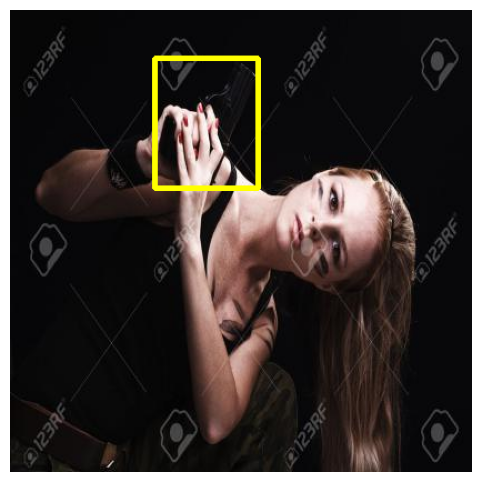

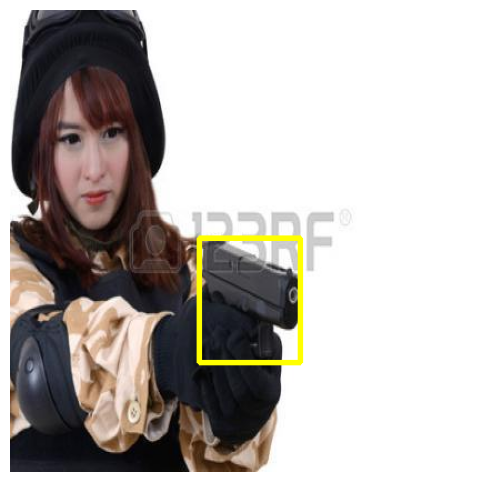

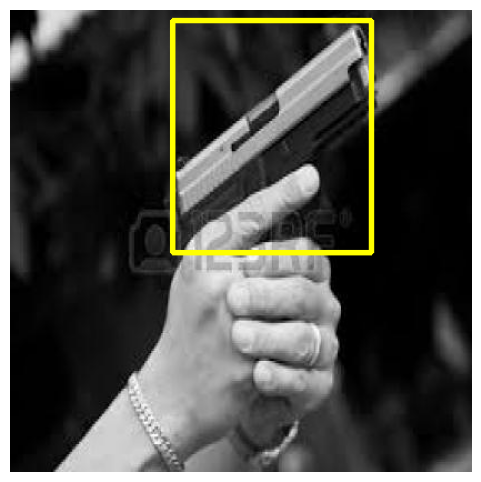

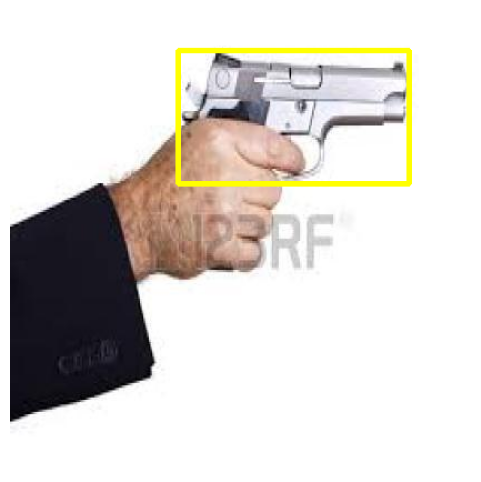

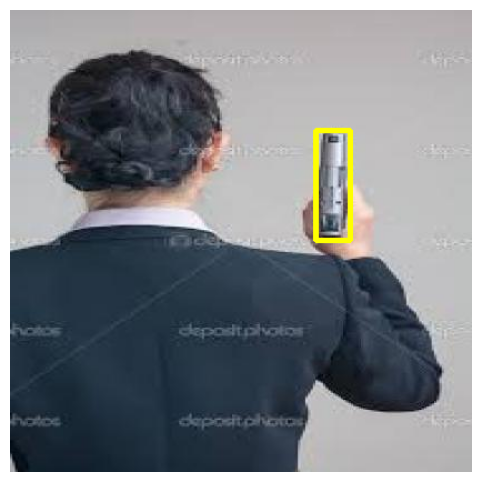

In [ ]:
import matplotlib.pyplot as plt
import cv2


img_h = 416
img_w = 416

def cv_coords(box):
  '''
  This function will convert B.B cordinates from (X_center,Y_center,width,height) format
  to (x_start,y_start,x_end,y_end) required for cv2 to annotate rectangle on objects
  '''
  x,y,w,h= box[1],box[2],box[3],box[4]
  x1, y1 = int((x-w/2)*img_w), int((y-h/2)*img_h)
  x2, y2 = int((x+w/2)*img_w), int((y+h/2)*img_h)
  return x1, y1, x2, y2


def plot_img_and_box(img, bbox):
  plt.figure(figsize=(6,6))
  print("ImgResolution",img.shape)
  bbox = cv_coords(bbox)
  start_point = (bbox[0],bbox[1])
  end_point = (bbox[2],bbox[3])
  img = cv2.rectangle(img,start_point,end_point,(255,255,0), 3)
  plt.axis('off')
  plt.imshow(img)

for i in range(5):
  img_path = f'{datapath}pistol_images/{i+1}.jpg'
  label_path = f'{datapath}pistol_annotations/{i+1}.txt'


  img = plt.imread(img_path)

  with open(label_path,'r') as f:
    bbox = (f.readlines())
    bbox = [float(element) for element in bbox[0].split(" ")]
    print(bbox)
  plot_img_and_box(img, bbox)

#### QUESTION: Think about strategy to find the location along with presence of Gun in the above Image:

###  **Classification + Localization**

- Discussion about how we can modify the CNN classification architectures taught in previous sessions to output bbox along with Class Probability score

Hint: last layer in FFN add single Neuron for Classification and 4 neurons in regression Head`

 <img src='https://drive.google.com/uc?id=1U4GAkmJ_kRLIozbvsSxwNSn-C84bCXmM'>

### Let's load the dataset into arrays:

In [ ]:
from tqdm.auto import tqdm
import numpy as np


def return_bbox(label_path):
  ''' read and return bbox from text file'''
  with open(label_path,'r') as f:
    bbox = (f.readlines())
    bbox = [float(element) for element in bbox[0].split(" ")]
    return bbox[0],bbox[1:]

def return_image_label(filename):
  '''
  read and return image as well as corresponding label and bbox from image file
  '''
  try:
    img_path = f'{datapath}pistol_images/{filename}.jpg'
    image = plt.imread(img_path)
    label_path = f'{datapath}pistol_annotations/{filename}.txt'
    class_label,bbox_label = return_bbox(label_path)
    return True,image,class_label,bbox_label
  except Exception as e:
    print("Exception: ",filename, str(e))
    return False,None,None, None


### Looping over all the files present in directory to extract image, labels and bbox
images, class_labels, bbox_labels = [], [],[]
for filename in tqdm(annot_files):
  filename = filename[:-4]
  status, image, class_label, bbox_label= return_image_label(filename)
  if status==True and image.shape==(416,416,3):
    images.append(image)
    class_labels.append(class_label)
    bbox_labels.append(bbox_label)


images,class_labels,bbox_labels = np.array(images),np.array(class_labels),np.array(bbox_labels)
images.shape, class_labels.shape, bbox_labels.shape

  0%|          | 0/3703 [00:00<?, ?it/s]

((3703, 416, 416, 3), (3703,), (3703, 4))

In [ ]:
class_labels

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
bbox_labels

array([[0.42538462, 0.24479737, 0.22153846, 0.28148959],
       [0.49839228, 0.49074074, 0.36655949, 0.45061728],
       [0.64666021, 0.28387097, 0.08131655, 0.05935484],
       ...,
       [0.66423077, 0.51078799, 0.45153846, 0.815197  ],
       [0.49666667, 0.49450549, 0.92666667, 0.79120879],
       [0.48653846, 0.45345188, 0.97153846, 0.90481172]])

#### Frequency Distribution of Gun and No Gun class

In [ ]:
np.unique(class_labels, return_counts=True)

(array([0., 1.]), array([ 999, 2704]))

- there are **999** images with **no guns** while **2704** images **with Guns** present in frame

#### Now we will divide our dataset into train and test splits

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_class, y_test_class, y_train_box, y_test_box  = train_test_split(
    images, class_labels, bbox_labels, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train_class.shape, y_test_class.shape,y_train_box.shape, y_test_box.shape,

((2592, 416, 416, 3),
 (1111, 416, 416, 3),
 (2592,),
 (1111,),
 (2592, 4),
 (1111, 4))

In [ ]:
y_train_box

array([[0.41620112, 0.56560284, 0.24022346, 0.10992908],
       [0.        , 0.        , 0.        , 0.        ],
       [0.48333333, 0.50518519, 0.75555556, 0.89481481],
       ...,
       [0.496875  , 0.5       , 0.98125   , 0.95      ],
       [0.5       , 0.47757848, 0.996875  , 0.95067265],
       [0.517     , 0.51201201, 0.694     , 0.96996997]])

In [ ]:
y_train_class

array([1., 0., 1., ..., 1., 1., 1.])

#### Let's create the architecture for generating BBOX Co-ordinates along with Class probability as discussed above:

In [ ]:
import tensorflow as tf

ResNet101 = tf.keras.applications.ResNet101(weights='imagenet',include_top=False,
                            input_tensor=tf.keras.layers.Input(shape=(416,416,3)))

ResNet101.trainable = False             # make trainable parameter as false

# add some trainable Dense layers
res_output = ResNet101.output
flat = tf.keras.layers.Flatten()(res_output)

# Classification head
x1 = tf.keras.layers.Dense(128,activation='relu')(flat)
x1 = tf.keras.layers.Dense(64,activation='relu')(x1)
x1 = tf.keras.layers.Dense(32,activation='relu')(x1)

# classification output: single class
clas_out = tf.keras.layers.Dense(1,activation='sigmoid',name='class_output')(x1)

# Regression head
x1 = tf.keras.layers.Dense(128,activation='relu')(flat)
x1 = tf.keras.layers.Dense(64,activation='relu')(x1)
x1 = tf.keras.layers.Dense(32,activation='relu')(x1)

# Regression output: 4 B.B Co-ordinates
reg_out = tf.keras.layers.Dense(4,activation='sigmoid', name='box_output')(x1)

ResNet101_final = tf.keras.models.Model(ResNet101.input,[reg_out,clas_out])

171446536/171446536 [==============================] - 9s 0us/step


In [ ]:
ResNet101_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 422, 422, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 208, 208, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 208, 208, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Model Configurations and Loss function mappings:

> Indented block



 <img src='https://drive.google.com/uc?id=1b95a0OuOQditpxSr-aGt5eVTTkSG3pre' width=700 height=350>

In [ ]:
# loss for Classification + Regression
losses = { "class_output":"binary_crossentropy",
          "box_output":"mean_squared_error"}

# loss weight: Optional
loss_weights = {"box_output":4.0,
          "class_output":1.0}

# metrics for both head to track
metrics = {"box_output":"mse",
          "class_output":"accuracy"}

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile model
ResNet101_final.compile(optimizer=opt,loss=losses,loss_weights=loss_weights,metrics=metrics)

#### Let's train the model

In [ ]:
# tensorboard setup for visualization
log_dir = "pistol_Log"
!rm -rf log_dir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# start training the model
history = ResNet101_final.fit(x=X_train, y={"class_output":y_train_class, "box_output":y_train_box},
                              validation_data=(X_test, {"class_output":y_test_class, "box_output":y_test_box}),
                              batch_size=32,
                              epochs=10,
                              callbacks=(tensorboard_callback)
                           )

Epoch 1/10
81/81 [==============================] - 85s 800ms/step - loss: 0.2548 - box_output_loss: 0.0450 - class_output_loss: 0.0748 - box_output_mse: 0.0450 - class_output_accuracy: 0.9765 - val_loss: 0.1358 - val_box_output_loss: 0.0264 - val_class_output_loss: 0.0303 - val_box_output_mse: 0.0264 - val_class_output_accuracy: 0.9955
Epoch 2/10
81/81 [==============================] - 66s 814ms/step - loss: 0.0988 - box_output_loss: 0.0241 - class_output_loss: 0.0026 - box_output_mse: 0.0241 - class_output_accuracy: 0.9985 - val_loss: 0.0830 - val_box_output_loss: 0.0168 - val_class_output_loss: 0.0157 - val_box_output_mse: 0.0168 - val_class_output_accuracy: 0.9973
Epoch 3/10
81/81 [==============================] - 65s 808ms/step - loss: 0.0718 - box_output_loss: 0.0177 - class_output_loss: 9.4645e-04 - box_output_mse: 0.0177 - class_output_accuracy: 0.9996 - val_loss: 0.0654 - val_box_output_loss: 0.0128 - val_class_output_loss: 0.0141 - val_box_output_mse: 0.0128 - val_class_out

- Both Class Loss and BBox loss are decreasing continously as expected.
- Let's Visualize the training on tensorboard

In [ ]:
# !pip install tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_dir}

#### Our Localization model is ready. Let's use it for inference and learn evaluation methods:

### Prediction and Evaluation

Let's predict Image from our testset

In [ ]:
def predict(input_img_arr, model ,mode='single'):
  if mode is 'single':
    input_img_arr = np.expand_dims(input_img_arr, axis = 0)
    pred_box, class_prob = model.predict(input_img_arr)
    return pred_box[0], class_prob[0]

  else:
    pred_box, class_prob = model.predict(input_img_arr)
    return pred_box, class_prob

predict(X_test[0], ResNet101_final)

(array([0.53958523, 0.3081458 , 0.07448691, 0.22560748], dtype=float32),
 array([1.], dtype=float32))

In [ ]:
predict(X_test[0:4], ResNet101_final, "batch")

(array([[5.3958511e-01, 3.0814546e-01, 7.4486807e-02, 2.2560771e-01],
        [4.1671807e-01, 4.3104801e-01, 2.1861598e-01, 3.7124982e-01],
        [1.7963430e-04, 7.8867655e-05, 1.8680481e-04, 2.7463898e-06],
        [7.2263286e-04, 8.7296641e-05, 1.7045537e-04, 5.9578946e-07]],
       dtype=float32), array([[1.0000000e+00],
        [9.9999785e-01],
        [3.5026903e-17],
        [3.5760831e-17]], dtype=float32))

### Evaluate MSE and BCE on test set

In [ ]:
eval_res = ResNet101_final.evaluate(X_test, {"class_output":y_test_class, "box_output":y_test_box})

35/35 [==============================] - 19s 532ms/step - loss: 0.0630 - box_output_loss: 0.0099 - class_output_loss: 0.0234 - box_output_mse: 0.0099 - class_output_accuracy: 0.9973


In [ ]:
print(f'''Total Loss: {eval_res[0]}\nBBox MSE Loss{eval_res[1]}\nClass BCE Loss: {eval_res[2]}\nBBox MSE: {eval_res[3]}\nAccuracy Score: {eval_res[4]}\n''')

Total Loss: 0.06298098713159561
BBox MSE Loss0.00990129355341196
Class BCE Loss: 0.023375799879431725
BBox MSE: 0.00990129355341196
Accuracy Score: 0.9972997307777405



Plot Predicted Bounding Boxes Against Ground Truth Boxes

Ground Truth:  [0.50625    0.45416667 0.9125     0.89166667]
Predicted Bbox : [0.47375596 0.4802968  0.92174673 0.96721107]
ImgResolution (416, 416, 3)


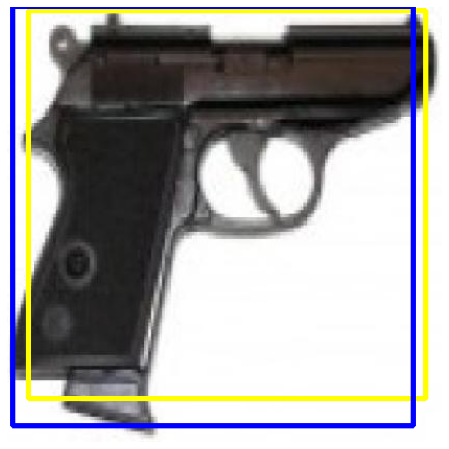

In [ ]:
import matplotlib.pyplot as plt
import cv2


def cv_coords(box):
  '''
  This function will convert B.B cordinates from (X_center,Y_center,width,height)  format
  to (x_start,y_start,x_end,y_end) required for cv2 to create rectangle
  '''
  x,y,w,h= box[0],box[1],box[2],box[3]
  x1, y1 = int((x-w/2)*img_w), int((y-h/2)*img_h)
  x2, y2 = int((x+w/2)*img_w), int((y+h/2)*img_h)
  return x1, y1, x2, y2



def plot_prediction(img, label, pred):
  img = img.copy()
  plt.figure(figsize=(8,8))
  print("ImgResolution",img.shape)

  # annotate ground truth
  bbox = cv_coords(label)
  start_point = (bbox[0],bbox[1])
  end_point = (bbox[2],bbox[3])
  img = cv2.rectangle(img,start_point,end_point,(255,255,0), 3)
  cv2.putText(img, 'Ground Truth', (start_point[0],start_point[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))


  # annotate prediction
  bbox = cv_coords(pred)
  start_point = (bbox[0],bbox[1])
  end_point = (bbox[2],bbox[3])
  img = cv2.rectangle(img,start_point,end_point,(0,0,255), 3)
  cv2.putText(img, 'Prediction', (start_point[0],start_point[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))


  plt.axis('off')
  plt.imshow(img)

# set index which will be used for prediction and plot
index = 500

label = y_test_box[index]

img = X_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ",label )
print("Predicted Bbox :", pred_box)

plot_prediction(img, label, pred_box)

Ground Truth:  [0.5125     0.49166667 0.95       0.96666667]
Predicted Bbox : [0.46633035 0.5589273  0.9450195  0.96038187]
ImgResolution (416, 416, 3)


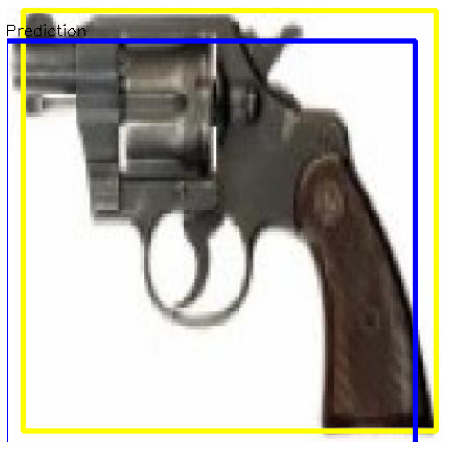

In [ ]:
index = 101

label = y_test_box[index]

img = X_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ",label )
print("Predicted Bbox :", pred_box)

plot_prediction(img, label, pred_box)

Ground Truth:  [0. 0. 0. 0.]
Predicted Bbox : [1.5601865e-03 1.4866996e-04 2.8225625e-04 1.4089792e-05]
ImgResolution (416, 416, 3)


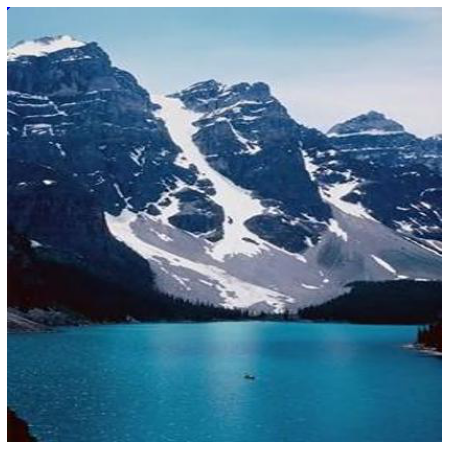

In [ ]:
index = 5

label = y_test_box[index]

img = X_test[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ",label )
print("Predicted Bbox :", pred_box)

plot_prediction(img, label, pred_box)

### Question: Is there a better way to Evaluate Bounding Box predictions?

### Question: Can we consider the Area of OverLap between predicted and True Bounding Box Rectangles?

- Introducing IoU as BBox Evaluation Metric




 <img src='https://drive.google.com/uc?id=13cmmDLI-6QfPRIjc_D-cLnWfcneWVs56'>

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/611/original/Screenshot_2023-09-11_at_10.29.47_AM.png?1694408427 height = 500 width=600>

Ground Truth:  [0.21939954 0.43021583 0.26096998 0.23741007]
Predicted Bbox : [0.27369243 0.33731556 0.2626449  0.27189463]
ImgResolution (416, 416, 3)


0.38374425772851495

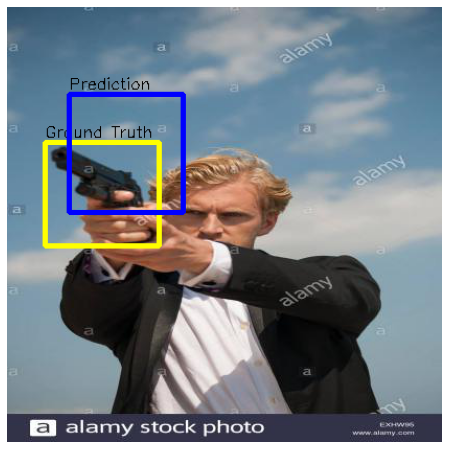

In [ ]:
def compute_iou(label_box, pred_box):
  # determine the (x, y)-coordinates of the intersection rectangle
  gt = [0,0,0,0]
  x1,y1,x2,y2 = cv_coords(label_box)
  gt[0],gt[1],gt[2],gt[3] = x1,y1,x2,y2

  pred = [0,0,0,0]
  x1,y1,x2,y2=cv_coords(pred_box)
  pred[0],pred[1],pred[2],pred[3] = x1,y1,x2,y2

  inter_box_top_left = [max(gt[0], pred[0]), max(gt[1], pred[1])]
  inter_box_bottom_right = [min(gt[0]+gt[2], pred[0]+pred[2]), min(gt[1]+gt[3], pred[1]+pred[3])]

  inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
  inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

  intersection = inter_box_w * inter_box_h
  union = gt[2] * gt[3] + pred[2] * pred[3] - intersection

  iou_area = intersection / (union+10e-3)
  return iou_area


index = 100

label = y_train_box[index]

img = X_train[index]
pred_box, class_prob = predict(img, ResNet101_final)

print("Ground Truth: ",label )
print("Predicted Bbox :", pred_box)

plot_prediction(img, label, pred_box)
compute_iou(label, pred_box)

#### Mean IOU:
- We can also calcualte mean IoU by simply calculating IoU for all the Images in test set and taking Average:

In [ ]:
def mean_intersection_over_union(X_test,gt_box, pred_box):
    iou = []
    for ind in range(len(X_test)):
      iou_area = compute_iou(gt_box[ind],pred_box[ind] )
      iou.append(iou_area)
    iou = np.array(iou)
    return np.mean(iou)

gt_box = y_train_box
pred_box = predict(X_train, ResNet101_final, 'batch')[0]

train_meanIOU = mean_intersection_over_union(X_train, gt_box, pred_box)

print(f'Mean IoU Train: {train_meanIOU}')

Mean IoU Train: 0.7423182413946467


In [ ]:
gt_box = y_test_box
pred_box = predict(X_test, ResNet101_final, 'batch')[0]

test_meanIOU = mean_intersection_over_union(X_test, gt_box, pred_box)

print(f'Mean IoU Test: {test_meanIOU}')

Mean IoU Test: 0.44792014324682944


### Conclusion for Object Localization and detection:

* Now you know the **Architecture of Object Localization**.
* It's output is fixed that is **4 output co-ordinates** that means **only 1 Bounding box**.
* So, in **Object Localization** we can only **Localize a single Object Present in the image**.

### Question: How can we find Multiple Objects in the image?
The family of Algorithm in which we can **classify and locate Multiple Objects** and **draw Bounding Box around them** are known as **Object Detection** Algorithm.

 <img src='https://drive.google.com/uc?id=1caneAt9OLzeg-kuenFbdTzUus08dcDyB' width=500 height=300>

 ## What is Sliding Window Detection?

**Sliding windows**: **“Slide”** a box around image and `classify each image crop` inside a box **(contains object or not?)**.

* **Classifying each image crop** into **car or not car** make **Object Detection** as a `classification problem`.

* Below Image shows how **Sliding Window** of **Particular size** `move across the image and Predict the car at particular location.`

 <img src='https://drive.google.com/uc?id=1lSq0z1ix_dnYwM54uWKtffBR-Id5HhIH' width=500 height=300>

### How do we Decide the size of Window?
* Since there is a possibility of different sizes objects present in the Image.
* We have to take Sliding window of **different sizes and scale**.
* And test all sliding window on the image.


**Disadvantage of Sliding Windows**: The **computational cost**.
* Because you're cropping out so many different square regions in the image and running each of them independently through a convNET, it's going to take many rounds of prediction through the model for just a single Image
- This can be reduced by reducing the number of windows and increasing Stride.
- Single Object detected multiple times across window scales

Alternatively we can use CNN itself to perform Sliding window:

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/612/original/Screenshot_2023-09-11_at_10.31.27_AM.png?1694408497 width=800>

#### Question: How can we Handle single Object getting detected multiple times across different windows and window scales?

<img src=https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/047/613/original/Screenshot_2023-09-11_at_10.32.10_AM.png?1694408549 height = 500 width=600>

`Introduce Multiple Detections for objects spread across windows and Scales with Image`

### Introduce NMS to Suppress BBOXES

 <img src='https://drive.google.com/uc?id=1gRnAkoJOmem8Sx_7kJcfaveN7lAAMO-t'>

### QUESTION: Implement NMS using the steps given below:
**Algorithm**:
1. Select the **proposal with highest confidence score**, remove it from initial proposal List and `append it to a new final proposal list.`
2.Now compare this proposal with all the proposals — **calculate the IOU of this proposal with every other proposal**.
3. If the `IOU is greater than the threshold hyper-parameter N (range(0,1))`, remove that proposal from initial proposal List.
4. Again take the proposal with the **highest confidence from the remaining proposals** in initial proposal List and `push it to the final proposal list.`
5. Calculate IOU of proposal selected in step 4 and delete proposals which has IoU greater then the threshold N.
6. Repeat step 4 and 5 ` until there are no more proposals left in initial proposal List.`

In [ ]:
# ### Implement NMS
def non_max_suppress(conf, xy_min, xy_max, threshold=.4):
    _, _, classes = conf.shape
    boxes = [(_conf, _xy_min, _xy_max) for _conf, _xy_min, _xy_max in zip(conf.reshape(-1, classes), xy_min.reshape(-1, 2), xy_max.reshape(-1, 2))]

    # Iterate each class
    for c in range(classes):
        # Sort boxes
        boxes.sort(key=lambda box: box[0][c], reverse=True)
        # Iterate each box
        for i in range(len(boxes) - 1):
            box = boxes[i]
            if box[0][c] == 0:
                continue
            for _box in boxes[i + 1:]:
                # Take iou threshold into account
                if compute_iou(box[1], box[2], _box[1], _box[2]) >= threshold:
                    _box[0][c] = 0
    return boxes


----

* Untill now we were able to frame object detection as classification, simply by utilizing sliding windows.
* The problems with this approach is : **we have to test many positions and scales and then pass it to CNN, which is computationally very expensive.**

#### Question: CAN WE OPTIMIZE OUR ALGORITHM FURTHER ?

Ans: By reducing the regions where object is not present


## Introducing **TWO STAGE DETECTOR:**
RCNN (Regions + CNN) is a method that relies on a external region proposal systemg to find and extract region of interest(Regions where some object might be present).

The family of RCNN and it's successor are also known as two stage detectors as:
1. At first stage, Propose some Regions from the image where ther is a chance of Object present.
2. Then at second stage, the Regions proposed by first stage are classified into different classes.

<img src='https://drive.google.com/uc?id=1teCO6iHXdwjBjiDp0fEwy_i5Au-WslVn' width900 height=400>

#### RCNN: Rich feature hierarchies for accurate object detection
 https://arxiv.org/abs/1311.2524



<img src='https://drive.google.com/uc?id=1VX90RmENzBJb3KEF5MjfDhWhe0zxivgO' width=700 height=400>

An overview of the R-CNN algorithm can
be found in above figure, which can be dividing into following steps:
* **Step 1:** Extract regions proposals (i.e., regions of the input image that potentially contain objects)
using an algorithm such as **Selective Search**.
* **Step 2:** `Use transfer learning`, specifically **feature extraction**, **to compute features for each proposal** (`which is effectively an ROI`) using a **pre-trained CNN** for example VGG-16 or Resnet.
* **Step 3:** Classify each proposal and calcuate BBOX Co-Ordinates using the extracted features with a **Support Vector Machine(SVM)** and **BBOX Regression** respectively.

### What is Selective Search? How Does it work?

Selective Search is a region proposal algorithm for object detection tasks. It starts by over-segmenting the image based on intensity of the pixels using a graph-based segmentation method similar to KMeans clusterting. Selective Search then takes these oversegments as initial input and performs the following steps

1. Add all bounding boxes corresponding to segmented parts to the list of regional proposals
2. Group adjacent segments based on similarity
3. Go to step 1 until a predefined number of bounding boxes are reached(typically 2000)

**Advantage: Selective Search is far more computationally efficient than exhaustively computing image pyramids and sliding windows**

https://learnopencv.com/selective-search-for-object-detection-cpp-python/



<img src='https://drive.google.com/uc?id=1kC9gKyDFrMGXjzHjTldd6zsAo66hHiFq' width=700 height=300>

## Is it possible to obtain end-to-end deep learning-based object detection?

* Approximately after a year the successor of R-CNN was introduced as **Fast R-CNN**.
* Similar to the original R-CNN, **Fast R-CNN algorithm also utilizes Selective Search to obtain region proposals**.
* But a novel change was made: **Region of Interest (ROI) Pooling**
* Thanks to **ROI Pooling** the `SVM layer was replaced by CNN Layers followed by Fully connected layers` as ROI Pooling as brought all the proposed regions to same scale/dimension

### Fast R-CNN: https://arxiv.org/abs/1504.08083

<img src='https://drive.google.com/uc?id=10ZnS8lHgRb36KMMid2otKv7a443WKlTj' width=1800 height=300>

* In the **Fast R-CNN architecture**, we still use **Selective Search to obtain our proposals**,
but now we apply **ROI Pooling by extracting a fixed-size window from the feature map** and `using
these features to obtain the final class label and bounding box`.

Let's see the Fast R-CNN Architecture in detail

* In this new approach, we apply **the CNN(pre-trained)** to the entire input image and **extract a feature map**.
* **ROI Pooling works by extracting a fixed-size window from the feature map** and then passing it into a set of `fully-connected layers to obtain the output label for the ROI.`
* We’ll discuss ROI Pooling in more detail later, but for the time being, understand that **ROI Pooling operates over the feature map extracted from the CNN and extracts a fixed-size window from it.**

<img src='https://drive.google.com/uc?id=1g4CaEIh4nx7luxahQpHQm5JbligbradT' width=800 height=400>

The primary benefit here is that the network is now, effectively, end-to-end trainable:
1. `We input an image and associated ground-truth bounding boxes`.
2. **Extract the feature map**
3. Apply **ROI pooling** and obtain **the ROI feature vector**.
4. And finally use two sets of fully-connected layers to obtain <br>
 (1) **the class label predictions** and <br>
 (2) the **bounding box locations** for each proposal. <br>

#### What is ROI Pooling?
It's a type of max-pooling with a pool size dependent on the input, so that the output always has the same size. This is done because fully connected layer always expected the same input size.

<img src='https://drive.google.com/uc?id=1YJ9BVHcaIjJQ7Ja8-ygphfHE-ZQTarsx'>

### Region of interest pooling — example
- Let’s consider a small example to see how it works.
- We’re going to perform region of interest pooling on a **single 8×8 feature map**, one region of interest and **an output size of 2×2**. Our input feature map looks like this:

<img src='https://drive.google.com/uc?id=1WI9BdsNNseBymT8Atso44aw92UXL4riK'>

To Include: Corresponding GUN Image

Let’s say we also have a region proposal (top left, bottom right coordinates): (0, 3), (7, 8). In the picture it would look like this:


<img src='https://drive.google.com/uc?id=1F1qo_GPH6JG6ODFCuhpq2grSHy8zLdcj'>

Normally, there’d be multiple feature maps and multiple proposals for each of them, but we’re keeping things simple for the example.
By dividing it into (2×2) sections (because the output size is 2×2) we get:


<img src='https://drive.google.com/uc?id=13ZDAgUcCaDicZlvYA11popS80z5Atbkk'>

Note that the size of the region of interest doesn’t have to be perfectly divisible by the number of pooling sections (in this case our RoI is 7×5 and we have 2×2 pooling sections).
The max values in each of the sections are:

<img src='https://drive.google.com/uc?id=1m4GSFUvMRizKWpJDiVUVE8CqjkHGqGNV'>

**This operation can be applied over all the Proposed ROI's of Different Width and Height to get uniform output size** and the batch of output from the Region of Interest pooling layer can be passed down to Fully Connected Layer for **BBOX Prediction and Classification in a Single Forward Pass**

### Question: We just saw how the gun at bottom-left area in the image is passed through ROI Pooling layer to calculate 2x2 output size. Calculate the output for the smaller gun on Top-Right:

<img src = 'https://drive.google.com/uc?id=1yKOVU37aikVu_12HJoaffL1hKROHsI2i'>

### Drawback of FastRCNN:
- Only Major downside of Fast RCNN is the Region Proposal which are still coming from Selective Search.
- The problem with the Selective Search is that it's an offline algorithm whoch doesn't adapt with training data and also computationally very expensive.


In Order to make make the **Fast R-CNN architecture even faster** we need to incorporate the **region proposal using CNN directly**

Let's see how we can do this

### Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks https://arxiv.org/pdf/1506.01497.pdf

<img src='https://drive.google.com/uc?id=1YPl2BOEvXpB2znRUrt9A6XCpZnTKlSm-' width=600 height=500>


The main idea is use the **last conv layers of Backbone to infer region proposals**.

Faster-RCNN consists of two modules.
* **RPN (Region proposals):** Gives a set of rectangles based on deep convolution layer
* **Fast-RCNN Roi Pooling layer:** Classify each proposal, and refining proposal location.

Here we break the above block diagram to show how **Faster RCNN works**:
1. Get a **trained (ie imagenet) convolution neural network.**
2. Get **feature maps** from the `last (or deep) convolution layer`.
3. Train a **region proposal network** that will decide if there is an object or not on the image, and also propose a box location.
4. Give results to a custom (python) layer.
5. Give proposals to a **ROI pooling layer (like Fast RCNN).**
6. After all proposals get reshaped to a fix size, send to a **fully connected layer to continue the classification**.

### Region proposal Network

- A Region Proposal Network, or RPN, is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals.

- RPN and algorithms like Fast R-CNN can be merged into a single network by sharing their convolutional features - using the recently popular terminology of neural networks with attention mechanisms, the RPN component tells the unified network where to look.

- RPNs are designed to efficiently predict region proposals with a wide range of scales and aspect ratios. RPNs use anchor boxes that serve as references at multiple scales and aspect ratios.

- The scheme can be thought of as a pyramid of regression references, which avoids enumerating images or filters of multiple scales or aspect ratios.

**How RPN works?**
1.  Feature Extraction using pre-trained CNN: In feature extraction phase we can use any pre-trained network such as VGG-16 or Resnet Variations to extract features from input batch of images

2. Generate anchor boxes: We manually define many Anchor boxes across the full image dimension and label its object class if object center lies at anchor box center. Each box has a certain height and width which is selected based on the heights and widths of objects in a training dataset.
3. Classify Anchor Boxes: To classify each anchor box, RPN uses Intersection over Union (IOU) distance metric by calculating overlap of anchor box with the desired object. If anchor box having IOU greater than 0.5, it will be considered foreground and those having less than 0.1 IOU are considered background
4. Bounding box regression adjustment: In this step regression layer tries to make the coordinates of the bounding box around the desired object more precise. Coordinates of the object are width, height and depth (or called center).

<img src='https://drive.google.com/uc?id=1BLAoqftXWi98GxVNLroCGZ_21xJfMbX9' width=700 height=400>

Loss function of Regional Proposal Network is the sum of classification (cls) and regression (reg) loss.

<< Check Equation (1) in the research paper: https://arxiv.org/pdf/1506.01497.pdf >>

To Summarize RPN the Image passes through CNN and get feature map. For each position in the feature map, you have anchor boxes and for every anchor box RPN Calculates the probability of Object Being present or Not alongwith Bbox OFFSET Associated with it if object is present.

### Faster RCNN training

On the paper, each network was trained separately, but we also can train it jointly.

we have to consider the model with following 4 losses:
* RPN Classification (Object or not object)
* RPN Bounding box proposal
* Fast RCNN Classification (Normal object classification)
* Fast RCNN Bounding-box regression (Improve previous BB proposal)

<img src='https://drive.google.com/uc?id=1beUNHBXrlxqOIMK9LrWjNCeJ5v733pgT' width=700 height=800>

Given below is comparison of Speed and mAP metric for all three versions of RCNN on VOC2007 Dataset


<img src='https://drive.google.com/uc?id=1-l0eJMA0SZk5jVf1xpYx5eWWrobDqKtZ'>

<img src='https://drive.google.com/uc?id=1aTkp4jt4l76Z_sP0WeT9Ja1N_fCzflY_'>

## [Below part is Optional]

Code Implentation of Backbone for FasterRCNN(VGG:

<img src='https://drive.google.com/uc?id=1sJ1LQ3FU5Ldqz_Q1VY-Yo-ZfJUwxjpxL' width=800>

In [ ]:
def partial_vgg(input_tensor=None):

    input_shape = (None, None, 3)

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    print(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    print(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    print(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    print(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # We are not using fully connected layers (3 fc layers) as we need feature maps as output from this network.

    return x

Code Implementation OF RPN:

In [ ]:
""
#RPN layer
def rpn_layer(base_layers, num_anchors):

    #cnn_used for creating feature maps: vgg, num_anchors: 9
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(base_layers)

    #classification layer: num_anchors (9) channels for 0, 1 sigmoid activation output
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid')(x)

    #regression layer: num_anchors*4 (36) channels for computing the regression of bboxes
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear')(x)

    return [x_class, x_regr, base_layers] #classification of object(0 or 1),compute bounding boxes, base layers vgg

Code Implementation of ROI Pooling Layer:

In [ ]:
class RoiPoolingConv(Layer):
  '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''

    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)


        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels) : (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
#Classifier layer

def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):

    # base_layers: vgg
    #input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    #num_rois: number of rois to be processed in one time (4 in here)

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = Flatten(name='flatten')(out_roi_pool) #expanded into a vector with 25,088 (7×7×512) channels.
    out = Dense(4096, activation='relu', name='fc1')(out)
    out = Dropout(0.5)(out)
    out = Dense(4096, activation='relu', name='fc2')(out)
    out = Dropout(0.5)(out)

    # two output layer- classifier and regressor
    # for classify the class name of the object
    out_class = Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes)(out)

    #for bboxes coordinates regression
    out_regr = Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes)(out)

    return [out_class, out_regr]

Implementation:
https://github.com/AarohiSingla/Faster-R-CNN-on-Custom-Dataset/blob/main/training_fasterrcnn.ipynb

## Conclusion:
- You learnt how we can build our own object detector from scratch for object detection
- You also learnt about evaluation metric used for Object Detection tasks
- RCNN Family

In the Second part of today's lecture you are going to learn how can we use TFOD Framework in tensorflow to run inferences using any pre-trained model.

## **Lasso Regularization(L1)**

$Loss = \sum_{i=0}^{n} (y_i - X_i w)^2 + \sum_{j=0}^{d} |w_j|$

## **Ridge Regularization(L2)**

$Loss = \sum_{i=0}^{n} (y_i - X_i w)^2 + \sum_{j=0}^{d} w_j^2$